# Assignment 3

## 1. Setup

In [196]:
# Imports 
    # Copied from exmaple notebook 
    
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import pandas as pd
from __future__ import annotations
from typing import Tuple, List, Iterable, Dict, Optional
import matplotlib.pyplot as plt
import random
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed 
import math
import os
from dataclasses import dataclass
from collections import defaultdict



# Baseline Analysis
Run a baseline system analysis for the EV Stag Hunt model:
- Heatmap of final adoption X* vs (X0, I0)
- Phase plots (I(t), X(t)) for representative initial conditions
- Sensitivity curves: final adoption vs beta_I for several X0

Produces PNG plots and CSV data in ./output_ev_analysis/

### Model Implementation

In [3]:
from __future__ import annotations
# Strategy update functions

def choose_strategy_imitate(agent, neighbors):
    """Choose strategy of the highest-payoff neighbour (including self)."""
    candidates = neighbors + [agent]
    best = max(candidates, key=lambda a: a.payoff)
    return best.strategy

# Agent and Model classes

class EVAgent:
    def __init__(self, node_id: int, model: "EVStagHuntModel", init_strategy: str = "D"):
        self.node_id = node_id
        self.model = model
        self.strategy = init_strategy  # "C" or "D"
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def step(self) -> None:
        """Compute payoff from interactions with neighbours."""
        I = self.model.infrastructure
        a0 = self.model.a0
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I

        neighbors = list(self.model.G.neighbors(self.node_id))
        if not neighbors:
            self.payoff = 0.0
            return

        payoff = 0.0
        for nbr in neighbors:
            other = self.model.node_agent_map[nbr]
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:  # D vs D
                payoff += b
        self.payoff = payoff

    def advance(self) -> None:
        """Compute next_strategy according to model's strategy_choice_func but DO NOT commit."""
        func = self.model.strategy_choice_func
        neighbors = [self.model.node_agent_map[n] for n in self.model.G.neighbors(self.node_id)]

        if func == "imitate":
            candidates = neighbors + [self]
            best = max(candidates, key=lambda a: a.payoff)
            self.next_strategy = best.strategy
        elif func == "logit":
            a_I = self.model.a0 + self.model.beta_I * self.model.infrastructure
            pi_C = 0.0
            pi_D = 0.0
            for other in neighbors:
                if other.strategy == "C":
                    pi_C += a_I
                    pi_D += self.model.b
                else:
                    pi_C += 0.0
                    pi_D += self.model.b
            tau = getattr(self.model, "tau", 1.0)
            denom = math.exp(pi_C / tau) + math.exp(pi_D / tau)
            P_C = math.exp(pi_C / tau) / denom if denom > 0 else 0.5
            self.next_strategy = "C" if random.random() < P_C else "D"
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

    def commit(self) -> None:
        """Apply next_strategy synchronously."""
        self.strategy = self.next_strategy


class EVStagHuntModel:
    def __init__(
        self,
        initial_ev: int,
        a0: float,
        beta_I: float,
        b: float,
        g_I: float,
        I0: float,
        seed: int | None,
        network_type: str,
        n_nodes: int,
        p: float,
        m: int,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
    ):
        self.random = random.Random(seed)
        self.seed = seed
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = float(I0)
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau

        # Build network
        if network_type == "ER":
            G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
        elif network_type == "WS":
            G = nx.watts_strogatz_graph(n_nodes, max(2, m), p, seed=seed)
        elif network_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, max(1, m), seed=seed)

        # if graph disconnected, keep largest connected component (avoids isolated nodes effects)
        if not nx.is_connected(G) and len(G) > 0:
            comp = max(nx.connected_components(G), key=len)
            G = G.subgraph(comp).copy()
        self.G = G

        # create agents: one per node
        nodes = list(self.G.nodes())
        total_nodes = len(nodes)
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(nodes, k_ev))
        self.node_agent_map: Dict[int, EVAgent] = {}
        for node in nodes:
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(node, self, init_strategy)
            self.node_agent_map[node] = agent

    def get_adoption_fraction(self) -> float:
        agents = list(self.node_agent_map.values())
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    def step(self) -> None:
        # compute payoffs
        for agent in list(self.node_agent_map.values()):
            agent.step()
        # choose next strategies (based on payoffs)
        for agent in list(self.node_agent_map.values()):
            agent.advance()
        # commit synchronously
        for agent in list(self.node_agent_map.values()):
            agent.commit()
        # update infrastructure: I <- clip(I + g_I*(X - I), 0, 1)
        X = self.get_adoption_fraction()
        I = self.infrastructure
        dI = self.g_I * (X - I)
        self.infrastructure = float(min(1.0, max(0.0, I + dI)))

def set_initial_adopters(model, X0_frac, method="random", seed=None, high=True):
    """Set a fraction of agents to EV adopters using different heuristics."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    k = int(round(X0_frac * n))

    for a in agents:
        a.strategy = "D"

    if k <= 0:
        return

    if method == "random":
        idx = rng.choice(n, size=k, replace=False)
        for i in idx:
            agents[i].strategy = "C"
        return

    if method == "degree":
        deg = dict(model.G.degree())
        ordered_nodes = sorted(deg.keys(), key=lambda u: deg[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return
    
    if method == "betweenness":
        bc = nx.betweenness_centrality(model.G, normalized=True)
        ordered_nodes = sorted(bc.keys(), key=lambda u: bc[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.unique_id in chosen:
                a.strategy = "C"
        return

    raise ValueError(f"Unknown method: {method}")

### Runner Utilities

In [198]:
def run_trial(
    X0_frac: float,
    I0: float,
    *,
    a0: float,
    beta_I: float,
    b: float,
    g_I: float,
    T: int,
    network_type: str,
    n_nodes: int,
    p: float,
    m: int,
    seed: Optional[int],
    strategy_choice_func: str,
    tau: float = 1.0,
    record_trajectory: bool = False,
) -> Tuple[float, Tuple[np.ndarray, np.ndarray]]:
    """Run a single trial. Returns final adoption and optional trajectories (X(t), I(t))."""
    initial_ev = int(round(X0_frac * n_nodes))
    model = EVStagHuntModel(
        initial_ev=initial_ev,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    X_traj = []
    I_traj = []
    for t in range(T):
        if record_trajectory:
            X_traj.append(model.get_adoption_fraction())
            I_traj.append(model.infrastructure)
        model.step()
    if record_trajectory:
        X_traj.append(model.get_adoption_fraction())
        I_traj.append(model.infrastructure)
    final = model.get_adoption_fraction()
    return final, (np.array(X_traj), np.array(I_traj))

### Analysis Functions

In [199]:
def heatmap_final_adoption(
    X0_grid: Iterable[float],
    I0_grid: Iterable[float],
    *,
    a0: float,
    beta_I: float,
    b: float,
    g_I: float,
    n_nodes: int,
    p: float,
    m: int,
    T: int,
    trials_per_cell: int,
    network_type: str,
    strategy_choice_func: str,
    tau: float,
    seed_base: int,
    out_dir: str,
) -> Tuple[List[float], List[float], np.ndarray]:
    """Compute mean final adoption X* for every (X0, I0) cell and save CSV."""
    X0_vals = list(X0_grid)
    I0_vals = list(I0_grid)
    H = np.zeros((len(I0_vals), len(X0_vals)), dtype=float)  # rows: I0, cols: X0
    meta = {}
    for i, I0 in enumerate(I0_vals):
        for j, X0 in enumerate(X0_vals):
            finals = []
            for k in range(trials_per_cell):
                seed = seed_base + i * 10000 + j * 100 + k
                final, _ = run_trial(
                    X0_frac=X0,
                    I0=I0,
                    a0=a0,
                    beta_I=beta_I,
                    b=b,
                    g_I=g_I,
                    T=T,
                    network_type=network_type,
                    n_nodes=n_nodes,
                    p=p,
                    m=m,
                    seed=seed,
                    strategy_choice_func=strategy_choice_func,
                    tau=tau,
                    record_trajectory=False,
                )
                finals.append(final)
            H[i, j] = float(np.mean(finals))
            meta[(I0, X0)] = {"finals": finals, "mean": float(np.mean(finals)), "std": float(np.std(finals))}
    # Save CSV
    df = pd.DataFrame(H, index=[f"I0={v:.3f}" for v in I0_vals], columns=[f"X0={v:.3f}" for v in X0_vals])
    df.to_csv(os.path.join(out_dir, "heatmap_final_adoption.csv"))
    return X0_vals, I0_vals, H

def sensitivity_betaI_with_trials(
    beta_vals: Iterable[float],
    X0_values: Iterable[float],
    *,
    I0: float,
    a0: float,
    b: float,
    g_I: float,
    n_nodes: int,
    p: float,
    m: int,
    T: int,
    trials: int,
    network_type: str,
    strategy_choice_func: str,
    tau: float,
    seed_base: int,
    out_dir: str,
) -> Tuple[List[float], List[float], np.ndarray]:
    """
    Compute final adoption vs beta_I for each initial X0 in X0_values.
    Returns all trial results (shape: [X0, beta_I, trial]) for mean ± std plotting.
    """
    beta_vals = list(beta_vals)
    X0_values = list(X0_values)
    all_trials = np.zeros((len(X0_values), len(beta_vals), trials), dtype=float)

    for i, X0 in enumerate(X0_values):
        for j, beta in enumerate(beta_vals):
            for k in range(trials):
                seed = seed_base + i * 10000 + j * 100 + k
                final, _ = run_trial(
                    X0_frac=X0,
                    I0=I0,
                    a0=a0,
                    beta_I=beta,
                    b=b,
                    g_I=g_I,
                    T=T,
                    network_type=network_type,
                    n_nodes=n_nodes,
                    p=p,
                    m=m,
                    seed=seed,
                    strategy_choice_func=strategy_choice_func,
                    tau=tau,
                    record_trajectory=False,
                )
                all_trials[i, j, k] = final

    # Optional: save mean results to CSV
    means = all_trials.mean(axis=2)
    df = pd.DataFrame(means, index=[f"X0={v:.3f}" for v in X0_values],
                      columns=[f"beta_I={v:.3f}" for v in beta_vals])
    df.to_csv(os.path.join(out_dir, "sensitivity_betaI_mean.csv"))

    return X0_values, beta_vals, all_trials    

def collect_trajectories(
    cases: List[Tuple[float, float]],
    *,
    a0: float,
    beta_I: float,
    b: float,
    g_I: float,
    n_nodes: int,
    p: float,
    m: int,
    T: int,
    network_type: str,
    strategy_choice_func: str,
    tau: float,
    seed_base: int,
    out_dir: str,
) -> Dict[Tuple[float, float], Dict]:
    """Run representative trajectories and return time-series, without plotting."""
    trajs = {}
    for idx, (X0, I0) in enumerate(cases):
        seed = seed_base + idx * 100
        final, (X_traj, I_traj) = run_trial(
            X0_frac=X0,
            I0=I0,
            a0=a0,
            beta_I=beta_I,
            b=b,
            g_I=g_I,
            T=T,
            network_type=network_type,
            n_nodes=n_nodes,
            p=p,
            m=m,
            seed=seed,
            strategy_choice_func=strategy_choice_func,
            tau=tau,
            record_trajectory=True,
        )
        trajs[(X0, I0)] = {"final": final, "X": X_traj, "I": I_traj}

    return trajs

### Configure and Run Analyses

In [193]:
# ============================================================
#  HEATMAP ANALYSIS
# ============================================================
def run_heatmap_analysis(
    out_dir,
    X0_grid,
    I0_grid,
    a0,
    beta_I,
    b,
    g_I,
    n_nodes,
    p,
    m,
    T,
    trials_per_cell,
    network_type,
    strategy_choice_func,
    tau,
    seed_base,
):
    print("Starting heatmap sweep (this may take some time)...")

    X0_vals, I0_vals, H = heatmap_final_adoption(
        X0_grid=X0_grid,
        I0_grid=I0_grid,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        n_nodes=n_nodes,
        p=p,
        m=m,
        T=T,
        trials_per_cell=trials_per_cell,
        network_type=network_type,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed_base=seed_base,
        out_dir=out_dir,
    )

    # Save heatmap figure
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        H,
        origin="lower",
        aspect="auto",
        extent=[X0_vals[0], X0_vals[-1], I0_vals[0], I0_vals[-1]],
    )
    plt.colorbar(im, label=r'Mean final adoption $X^*$')
    plt.xlabel(r'Initial adoption $X_0$')
    plt.ylabel(r'Initial infrastructure $I_0$')
    plt.title(fr'Heatmap: Mean final adoption $X^*$ vs ($X_0$, $I_0$) ($\beta_I$={beta_I:.2f})')
    plt.tight_layout()
    fname = os.path.join(out_dir, "heatmap_final_adoption.png")
    plt.savefig(fname)
    plt.close()

    print("Heatmap saved to:", fname)

    return X0_vals, I0_vals, H


# ============================================================
#  SENSITIVITY ANALYSIS
# ============================================================
def run_sensitivity_analysis(
    out_dir,
    beta_vals,
    X0_sens,
    I0,
    a0,
    b,
    g_I,
    n_nodes,
    p,
    m,
    T,
    trials,
    network_type,
    strategy_choice_func,
    tau,
    seed_base,
):
    print("Starting sensitivity sweep over beta_I ...")

    X0_list, betas, sens_res = sensitivity_betaI_with_trials(
        beta_vals=beta_vals,
        X0_values=X0_sens,
        I0=I0,
        a0=a0,
        b=b,
        g_I=g_I,
        n_nodes=n_nodes,
        p=p,
        m=m,
        T=T,
        trials=trials,
        network_type=network_type,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed_base=seed_base,
        out_dir=out_dir,
    )

    # Compute mean across trials
    mean_vals = np.mean(sens_res, axis=2)

    # Plot only the mean
    plt.figure(figsize=(7, 5))
    for i, x0 in enumerate(X0_list):
        plt.plot(betas, mean_vals[i, :], label=f"X0={x0:.2f}", marker="o", linewidth=1)

    plt.ylim(-0.05, 1.05)
    plt.xlabel(r'$\beta_I$')
    plt.ylabel(r'Mean Final Adoption $X^*$')
    plt.title(r'Sensitivity: Final Adoption vs $\beta_I$')
    plt.legend(title=r"Initial Adoption $X_0$")
    plt.tight_layout()

    fname = os.path.join(out_dir, "sensitivity_betaI_mean_only.png")
    plt.savefig(fname)
    plt.close()
    print("Sensitivity plot saved to:", fname)

    return X0_list, betas, mean_vals

# ============================================================
#  PHASE TRAJECTORY PLOTS
# ============================================================
def run_phase_plots(
    out_dir,
    phase_cases,
    a0,
    beta_I,
    b,
    g_I,
    n_nodes,
    p,
    m,
    T,
    network_type,
    strategy_choice_func,
    tau,
    seed_base,
):
    print("Collecting representative trajectories...")

    trajs = collect_trajectories(
        phase_cases,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        n_nodes=n_nodes,
        p=p,
        m=m,
        T=T,
        network_type=network_type,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed_base=seed_base,
        out_dir=out_dir,
    )

    print("Creating combined phase plot...")

    # -------------------------
    #  Combined Phase Plot
    # -------------------------
    plt.figure(figsize=(6, 5))
    for (I0, X0), data in trajs.items():
        plt.plot(
            data["X"],
            data["I"],
            label=f"X0={X0:.2f}, I0={I0:.2f}",
            linewidth=1.5
            # attribute a color scheme of green to the lines
        )

    plt.xlabel("Adoption X(t)")
    plt.ylabel("Infrastructure I(t)")
    plt.title("Phase Plot (I (t), X (t))")
    plt.legend(loc="upper left", fontsize=6)
    plt.grid(True)
    plt.tight_layout()

    fname_phase = os.path.join(out_dir, "phaseplot.png")
    plt.savefig(fname_phase)
    plt.close()

    # -------------------------
    #  Combined Time Series Plot
    # -------------------------
    plt.figure(figsize=(7, 5))
    for (X0, I0), data in trajs.items():
        t = np.arange(len(data["X"]))
        plt.plot(t, data["X"], label=f"X(t)  X0={X0:.2f}, I0={I0:.2f}", linewidth=1)
        plt.plot(t, data["I"], linestyle="--", label=f"I(t)  X0={X0:.2f}, I0={I0:.2f}")

    plt.xlabel("time step")
    plt.ylabel("value")
    plt.title("Combined Time Series for All Phase Cases")
    plt.legend(ncol=2, fontsize=8, loc="lower right")
    plt.tight_layout()

    #add a grid to the figure
    plt.grid()

    fname_time = os.path.join(out_dir, "timeseries_phase_cases.png")
    plt.savefig(fname_time)
    plt.close()

    print("Combined phase and time-series plots saved to:", out_dir)

    return trajs

In [194]:

# ============================================================
#  MAIN ORCHESTRATOR
# ============================================================
def main():
    out_dir = "output_ev_analysis"
    os.makedirs(out_dir, exist_ok=True)

    # ---- Config: adjust these for more/less compute ----
    a0 = 2.0
    b = 1.0
    g_I = 0.05

    network_type = "WS"  # "ER", "WS", or "BA"
    n_nodes = 200
    p = 0.05
    m = 2

    strategy_choice_func = "imitate"
    tau = 1.0
    T = 200

    X0_grid = np.linspace(0.0, 1.0, 20)
    I0_grid = np.linspace(0.0, 1.0, 20)
    trials_per_cell = 8

    beta_vals = np.linspace(0.0, 4.0, 20)
    X0_sens = [0.2, 0.3, 0.4, 0.5]
    sensitivity_trials = 8

    phase_cases = [
        (0.2, 0.2),
        (0.2, 0.5),
        (0.2, 0.8),
        (0.4, 0.2),
        (0.4, 0.5),
        (0.4, 0.8),
    ]

    seed_base_heatmap = 42
    seed_base_sensitivity = 42
    seed_base_phase = 42

    beta_I_baseline = 2.0
    
    # X0_vals, I0_vals, H = run_heatmap_analysis(
    #     out_dir, X0_grid, I0_grid, a0, beta_I_baseline, b, g_I,
    #     n_nodes, p, m, T, trials_per_cell,
    #     network_type, strategy_choice_func, tau,
    #     seed_base_heatmap
    # )

    # X0_list, betas, mean_vals = run_sensitivity_analysis(
    #     out_dir, beta_vals, X0_sens, 0.05, a0, b, g_I,
    #     n_nodes, p, m, T, sensitivity_trials,
    #     network_type, strategy_choice_func, tau,
    #     seed_base_sensitivity
    #  )
    
    trajs = run_phase_plots(
          out_dir, phase_cases, a0, beta_I_baseline, b, g_I,
          n_nodes, p, m, T,
          network_type, strategy_choice_func, tau,
          seed_base_phase
        )

    # ---- Tipping estimate (rough) ----
    #    threshold = 0.9
    #    tipping_estimates = []
    #    for i_idx, I0 in enumerate(I0_vals):
    #        row = H[i_idx, :]
    #        idxs = np.where(row >= threshold)[0]
    #        tipping_estimates.append(
    #            X0_vals[int(idxs[0])] if len(idxs) > 0 else np.nan
    #        )

    #   tipping_df = pd.DataFrame(
    #       {"I0": I0_vals, "min_X0_for_Xstar_ge_0.9": tipping_estimates}
    #   )
    #   tipping_df.to_csv(os.path.join(out_dir, "tipping_estimates.csv"))

    # ---- Artifact index ----
    artifact_index = {
        "heatmap_png": os.path.join(out_dir, "heatmap_final_adoption.png"),
        "sensitivity_png": os.path.join(out_dir, "sensitivity_betaI.png"),
        "phase_plots_dir": out_dir,
        "tipping_estimates_csv": os.path.join(out_dir, "tipping_estimates.csv"),
    }

    pd.DataFrame(
        list(artifact_index.items()),
        columns=["artifact", "path"]
    ).to_csv(os.path.join(out_dir, "artifact_index.csv"), index=False)

    print("All done. Artifacts written to:", out_dir)


if __name__ == "__main__":
    main()


Creating combined phase plot...
Combined phase and time-series plots saved to: output_ev_analysis
All done. Artifacts written to: output_ev_analysis


Reasoning for policy interventions:
Infrastructure shocks:
- local (if infrastructure for highly central nodes increases): popular destinations get EV charging stations
- global (if infrastructure increases everywhere)

Targeted seeding:
- 

Running Baseline (Random Seeding)...
Running Intervention (Degree Seeding)...
Running Intervention (Degree Seeding)...


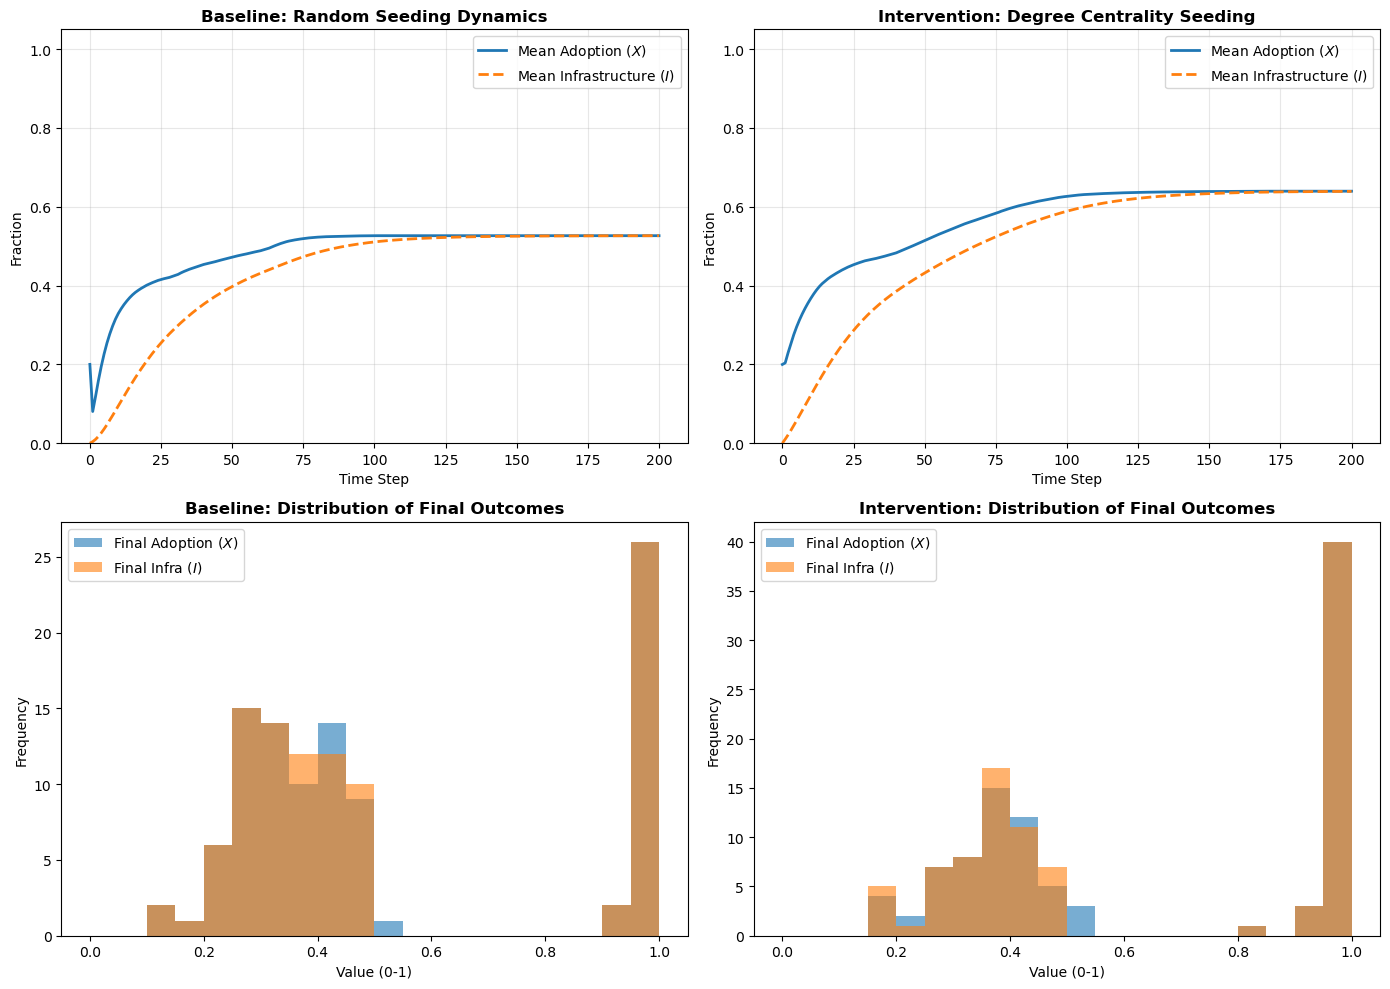

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

# --- 1. Helper Function for Targeted Seeding ---
def apply_seeding(model, X0_frac, method="random"):
    """
    Applies specific seeding strategies to the provided model instance.
    Adapts the logic to work with model.node_agent_map.
    """
    nodes = list(model.G.nodes())
    total_nodes = len(nodes)
    k_ev = int(round(X0_frac * total_nodes))
    
    # Reset all agents to Defect first
    for agent in model.node_agent_map.values():
        agent.strategy = "D"
        agent.next_strategy = "D"

    target_nodes = []

    if method == "random":
        target_nodes = random.sample(nodes, k_ev)
        
    elif method == "degree":
        # Sort nodes by degree (high to low)
        degrees = dict(model.G.degree())
        # Sort keys by value descending
        sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
        target_nodes = sorted_nodes[:k_ev]

    # Apply "C" strategy to chosen targets
    for node_id in target_nodes:
        model.node_agent_map[node_id].strategy = "C"
        model.node_agent_map[node_id].next_strategy = "C"

# --- 2. Simulation Runner ---
def run_batch(n_trials, steps, method, params):
    """
    Runs a batch of simulations and returns trajectories and final states.
    """
    X_trajectories = []
    I_trajectories = []
    final_X = []
    final_I = []

    for i in range(n_trials):
        # Initialize model with 0 initial EVs so we can manually seed them
        model = EVStagHuntModel(
            initial_ev=0, 
            a0=params['a0'], beta_I=params['beta_I'], b=params['b'], 
            g_I=params['g_I'], I0=params['I0'], 
            seed=None, # Random seed for stochasticity
            network_type=params['network_type'], 
            n_nodes=params['n_nodes'], p=params['p'], m=params['m'],
            strategy_choice_func=params['func']
        )
        
        # Apply the specific seeding method (Random vs Degree)
        apply_seeding(model, params['X0_frac'], method=method)
        
        # storage for this trial
        trial_X = []
        trial_I = []
        
        # Run time steps
        for t in range(steps):
            trial_X.append(model.get_adoption_fraction())
            trial_I.append(model.infrastructure)
            model.step()
            
        # Capture final state
        trial_X.append(model.get_adoption_fraction())
        trial_I.append(model.infrastructure)
        
        X_trajectories.append(trial_X)
        I_trajectories.append(trial_I)
        final_X.append(trial_X[-1])
        final_I.append(trial_I[-1])

    return np.array(X_trajectories), np.array(I_trajectories), np.array(final_X), np.array(final_I)

# --- 3. Configuration ---
# Parameters chosen to be near a tipping point where seeding matters
PARAMS = {
    'a0': 2.0,          
    'beta_I': 2,     # Strong feedback to allow tipping
    'b': 1.0,           # Defection payoff
    'g_I': 0.05,         # Infra growth rate
    'I0': 0.0,          # Start with no infrastructure
    'X0_frac': 0.20,     # 20% Initial adopters (Low initial seed)
    'network_type': 'WS', # Scale-free networks show high sensitivity to hubs
    'n_nodes': 200,
    'p': 0.05,           # For ER/WS
    'm': 2,             # For BA (edges per new node)
    'func': 'imitate'
}

TRIALS = 100
STEPS = 200

# --- 4. Execute Simulations ---
print("Running Baseline (Random Seeding)...")
base_X_traj, base_I_traj, base_final_X, base_final_I = run_batch(TRIALS, STEPS, "random", PARAMS)

print("Running Intervention (Degree Seeding)...")
seed_X_traj, seed_I_traj, seed_final_X, seed_final_I = run_batch(TRIALS, STEPS, "degree", PARAMS)

# Calculate Means
base_mean_X = np.mean(base_X_traj, axis=0)
base_mean_I = np.mean(base_I_traj, axis=0)
seed_mean_X = np.mean(seed_X_traj, axis=0)
seed_mean_I = np.mean(seed_I_traj, axis=0)

# --- 5. Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
time_axis = range(STEPS + 1)

# Style settings
color_X = '#1f77b4' # Blue
color_I = '#ff7f0e' # Orange
alpha_hist = 0.6

# --- Top Left: Baseline Dynamics ---
axs[0, 0].plot(time_axis, base_mean_X, label='Mean Adoption ($X$)', color=color_X, linewidth=2)
axs[0, 0].plot(time_axis, base_mean_I, label='Mean Infrastructure ($I$)', color=color_I, linewidth=2, linestyle='--')
axs[0, 0].set_title('Baseline: Random Seeding Dynamics', fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Fraction')
axs[0, 0].set_ylim(0, 1.05)
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].legend()

# --- Bottom Left: Baseline Histogram ---
axs[1, 0].hist(base_final_X, bins=20, range=(0,1), alpha=alpha_hist, color=color_X, label='Final Adoption ($X$)')
axs[1, 0].hist(base_final_I, bins=20, range=(0,1), alpha=alpha_hist, color=color_I, label='Final Infra ($I$)')
axs[1, 0].set_title('Baseline: Distribution of Final Outcomes', fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel('Value (0-1)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# --- Top Right: Targeted Seeding Dynamics ---
axs[0, 1].plot(time_axis, seed_mean_X, label='Mean Adoption ($X$)', color=color_X, linewidth=2)
axs[0, 1].plot(time_axis, seed_mean_I, label='Mean Infrastructure ($I$)', color=color_I, linewidth=2, linestyle='--')
axs[0, 1].set_title('Intervention: Degree Centrality Seeding', fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Fraction')
axs[0, 1].set_ylim(0, 1.05)
axs[0, 1].grid(True, alpha=0.3)
axs[0, 1].legend()

# --- Bottom Right: Targeted Seeding Histogram ---
axs[1, 1].hist(seed_final_X, bins=20, range=(0,1), alpha=alpha_hist, color=color_X, label='Final Adoption ($X$)')
axs[1, 1].hist(seed_final_I, bins=20, range=(0,1), alpha=alpha_hist, color=color_I, label='Final Infra ($I$)')
axs[1, 1].set_title('Intervention: Distribution of Final Outcomes', fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel('Value (0-1)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()